# COMP 8610: Assignment 2

Spencer Briguglio&nbsp;103 746 720</br>
Nour Elkot&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;104 982 352</br>
Karan Vishavjit&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;110 099 867

## Question 1
### Prepare the Data

In [32]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import logging
import math

# Set random seed
np.random.seed = 7

In [33]:
# Generate 5000 synthetic data points (x,y)
# Vector X
X_mu = 0
X_std = 1
X_ = np.random.normal(X_mu, X_std, size=(5000,1))

# Vector Eps
eps_mu = 0
eps_std = np.sqrt(0.25)
eps_ = np.random.normal(eps_mu, eps_std, size=(5000,1))

# Generate the Y vector
Y_ = np.zeros(shape=(1,5000))
Y_ = -1 + (0.5 * X_) - (2 * X_**2) + (0.3 * X_**3) + eps_

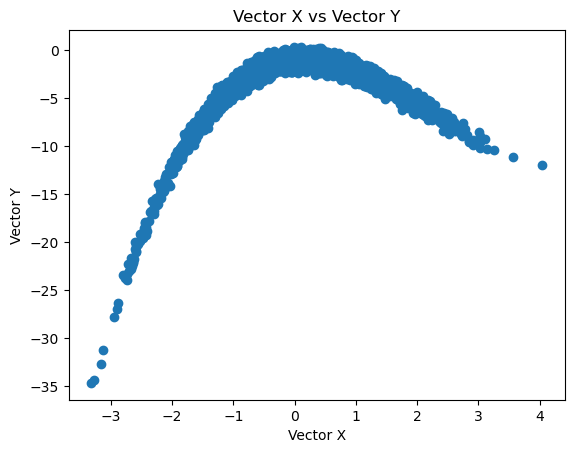

In [34]:
# Y vs X Scatterplot
plt.scatter(X_, Y_)

plt.title("Vector X vs Vector Y")
plt.xlabel("Vector X")
plt.ylabel("Vector Y")
plt.show()

## Adaline Neuron

In [49]:
# Define Neuron
class neuron:
    def __init__(self, mode="adaline", descent_method="bgd", dim=1, learning_rate=0.1, epochs=100):
        logger = logging.getLogger(__name__)
        # Check parameters
        try:
            if (mode != "adaline"   and
                mode != "sigmoid_e" and 
                mode != "sigmoid_tanh"):
                raise ValueError("Invalid mode, \"{}\", passed to neuron class. Expected \"adaline\" or \"sigmoid_e\" or \"sigmoid_tanh\".".format(mode))
            elif descent_method != "sgd" and descent_method != "bgd":
                raise ValueError("Invalid gradient descent method, \"{}\", passed to neuron class. Expected \"sgd\" or \"sigmoid\".".format(descent_method))
            
            self.mode = mode                        # Adaline OR Sigmoid (Logisitc Function) OR Sigmoid (tanh)
            self.descent_method = descent_method    # Batch/Standard Gradient Descent OR Stochastic Gradient Descent
        except ValueError as error:
            logger.error(error)
            raise
        
        # Internal
        self.dim = dim                              # Number of predictors
        self.W = np.random.rand(self.dim+1, 1)      # Initialize weights to small random value
        self.eta = learning_rate                    # Learning rate
        self.epochs = epochs                        # Maximum number of training rounds
        
    # Private
    def __activation(self, X_i):
        # Activation Functions
        def adaline(self, v):
            # Yes, I could return v. I added this for readability
            y_i = v
            return y_i
    
        def sigmoid_e(self, v):
            y_i = 1 / (1 + (math.e ** v))
            return y_i
    
        def sigmoid_tanh(self, v):
            y_i = math.tanh(v)
            return y_i
        
        # net input (weighted sum)
        v = self.W.T @ X_i
        if self.mode == "adaline":
            return adaline(v)
        elif self.mode == "sigmoid_e":
            return sigmoid_e(v)
        elif self.mode == "sigmoid_tanh":
            return sigmoid_tanh(v)
    
    # Training and Gradient Descent
    # Batch/Standard Gradient Descent
    def __train_bgd(self, X_):
        # Initialize weight delta vector
        delta_W = np.zeros(shape = self.W.shape)
        # For each sample x_i in X_
        for i in range(X_.shape[0]):
            y_i = self.__activation(X_[i])
            # For each weight vector component w_j in W
            for j in range(self.W.shape[0]):
                delta_W[j] = delta_W[j] + (self.eta * (Y_i[j] - y_i) * X_[i][j])
        
        # For each weight vector component w_j in W
        for j in range(self.W.shape[0]):
            self.W[j] = self.W[j] + delta_W[j]
        return
    
    # Stochastic/Incremental Gradient Descent
    def __train_sgd(self, X_, Y_):
        # For each sample x_i in X_
        for i in range(X_.shape[0]):
            y_i = self.__activation(X_[i])
            # For each weight vector component w_j in W
            for j in range(self.W.shape[0]):
                self.W[j] = self.W[j] + (self.eta * (Y_i[j] - y_i) * X_[i][j])
        return
    
    def __train(self, X_, Y_):
        if self.descent_method == "bgd":
            self.__train_bgd(X_, Y_)
            return self.MSE(X_, Y_)
        elif self.descent_method == "sgd":
            self.__train_sgd(X_, Y_)
            return self.MSE(X_, Y_)
    
    # MSE
    def __MSE(self, X_, Y_):
        sum_of_error = 0
        n = X_.shape[0]
        # for every sample in X_
        for i in range(n):
            y_i_hat = self.__activation(X_[i])
            squared_error = (Y_i[i] - y_i_hate) ** 2
            sum_of_error += squared_error
        return sum_of_error / n
    
    # Public
    def fit(self, X_, Y_):
        # Add x0=1 column to X_
        X_ = np.append(np.ones((X_.shape[0], 1)), X_, axis=1)
        delta_MSE = math.inf
        epoch = 0
        # while ? for ? until some termination condition is met
        while delta_MSE > 1 and epoch < self.epochs:
            self.__train(X_, Y_)
        return self.MSE(X_, Y_)
    
    def predict(self, X_):
        X_ = np.append(np.ones((X_.shape[0], 1)), X_, axis=1)
        y_pred = np.array([X_.shape[0], 1])
        # for every sample in X_, predict y_i_hat
        for i in range(X_.shape[0]):
            y_pred[i] = self.__activation(X_[i])
        return y_pred

In [28]:
n = neuron(mode="adaline", descent_method="bgd")